&nbsp;
<div style="text-align: center;">

## <span style="color: black;">Website SuperClassics - Europe Classic Cars</span>

&nbsp;

![SuperClassics Logo](superclassics_logo.png)

&nbsp;

### <span style="color: black;">Gartner Analysis</span>

#### <span style="color: #003E99"> *41 Brands, 944 suppliers* </font> </span>

## Index

- [<font color='black'> 1. Packages installation</font>](#1)

- [<font color='black'> 2. Data importation</font>](#2)

- [<font color='black'> 3. Data Normalization (Min-Max)</font>](#3)

- [<font color='black'> 4. Clustering </font>](#4)
    - [<font color='black'> 4.1. Elbow method </font>](#4.1)
    - [<font color='black'> 4.2. Silhouette plot and value </font>](#4.2)
    - [<font color='black'> 4.3. Final model </font>](#4.3)



## 1. Packages installation
<a id='1'>

In [1]:
#!pip3 install yellowbrick
#!pip3 install scipy

In [2]:
# dataframe
import pandas as pd

# array
import numpy as np

# normalization
from sklearn.preprocessing import MinMaxScaler

# graph
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.cluster import KMeans

#Metrics
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from scipy import stats


## 2. Data importation
<a id='2'>

In [3]:
#db0 = pd.read_csv('GoogleHits_suppliers_GoogleHits_QtdSuppliers_all')
db0 = pd.read_csv('Suppliers_factors')

In [4]:
db0.head()

,Brand,MostProducedCountry,Carbon_footprint_mean,Supplier_quantity,Google Hits,Carbon_footprint_mean_log,Google Hits_log,Supplier_quantity_log
0,AC,Australia,1044.000000,4,137000000,6.950815,18.735491,1.386294
1,Abarth,Belgium,1028.833333,4,24700000,6.936181,17.022314,1.386294
2,Alfa Romeo,Netherlands,720.161765,63,52800000,6.579476,17.782022,4.143135
3,Allard,United States,1002.000000,1,1890000,6.909753,14.452087,0.000000
4,Alvis,United Kingdom,1305.000000,5,3620000,7.173958,15.101985,1.609438


In [5]:

#remove brands not known
db0 = db0[~db0['Brand'].isin(['Glas','Mini','AC','American Brands','British Brands',
                              'Classic Car Dealer','Customs and Hot Rods', 'East German Brands', 
                              'European Brands','French Brands', 'German Brands',
                             'Italian Brands', 'Japanese Brands','Kitcars', 'Military Vehicles',
                             'Pre-War Cars', 'Prestige and Supercars', 'Race and rally cars',
                             'Russian Brands', 'Trucks and Trailers','Ford (USA)','Youngtimers', 'Caterham','Packard',
                             'Trabant', 'Studebaker', 'Hillman', 'Marcos','TVR'])]

In [6]:
list = db0['Brand'].unique().tolist()
print(list)

['Abarth', 'Alfa Romeo', 'Allard', 'Alvis', 'Aston Martin', 'Austin', 'BMW', 'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Citroën', 'DKW', 'Daimler', 'Datsun', 'De Tomaso', 'Facel Vega', 'Ferrari', 'Fiat', 'Ford', 'Holden', 'Lancia', 'Land Rover', 'Lotus', 'MG', 'Maserati', 'Mazda', 'Morgan', 'Morris', 'NSU', 'Opel', 'Panhard', 'Peugeot', 'Pontiac', 'Porsche', 'Range Rover', 'Reliant', 'Renault', 'Riley', 'Rover', 'Saab', 'Simca', 'Subaru', 'Toyota', 'Triumph', 'Volkswagen', 'Škoda']


In [7]:
len(list)

49

## 3. Data Normalization (Min-Max)
<a id='3'>

<span style='color:blue'> Choose the Top X Google Hits

In [8]:
db = db0.sort_values(by='Google Hits', ascending=False).head(100)

In [9]:
db.reset_index(drop=True, inplace=True)

In [10]:
db1 = db.copy()
columns_to_normalize = ['Supplier_quantity', 'Google Hits']

# MinMax
scaler = MinMaxScaler(feature_range=(0,1))
db2 = pd.DataFrame(scaler.fit_transform(db1[columns_to_normalize]),columns=[col + '_mm' for col in columns_to_normalize])

# new columns
db1 = pd.concat([db1, db2], axis=1)
db1.head()

,Brand,MostProducedCountry,Carbon_footprint_mean,Supplier_quantity,Google Hits,Carbon_footprint_mean_log,Google Hits_log,Supplier_quantity_log,Supplier_quantity_mm,Google Hits_mm
0,Ford,Germany,843.933333,15,225000000,6.738074,19.231611,2.708050,0.065728,1.000000
1,BMW,Germany,713.313725,51,183000000,6.569921,19.024997,3.931826,0.234742,0.812661
2,Toyota,Germany,560.500000,4,170000000,6.328829,18.951309,1.386294,0.014085,0.754676
3,Volkswagen,Germany,831.708609,157,131000000,6.723482,18.690708,5.056246,0.732394,0.580718
4,Porsche,Germany,693.765258,214,125000000,6.542134,18.643824,5.365976,1.000000,0.553956


## 4. Clustering 
<a id='4'>

### 4.1. Elbow method
<a id='4.1'>

C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

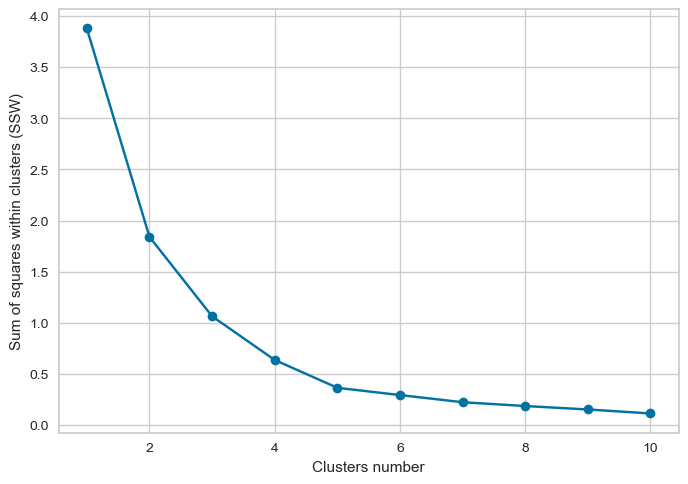

In [11]:
data = db1[['Supplier_quantity_mm', 'Google Hits_mm']]

cost = []

for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(data)
    
    cost.append(kmeans.inertia_)


plt.plot(range(1, 11), cost, marker='o')
plt.xlabel('Clusters number')
plt.ylabel('Sum of squares within clusters (SSW)')
plt.savefig('Modelling_GH_qtdSuppliers_elbow_maxsamplesize.eps')
plt.savefig('Modelling_GH_qtdSuppliers_elbow_maxsamplesize.png')
plt.show()

<span style='color:blue'> The elbow method shows that data should be split in four ou five clusters, according to the inflection point equal to four.

### 4.2. Silhouette plot and value
<a id='4.2'>

C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

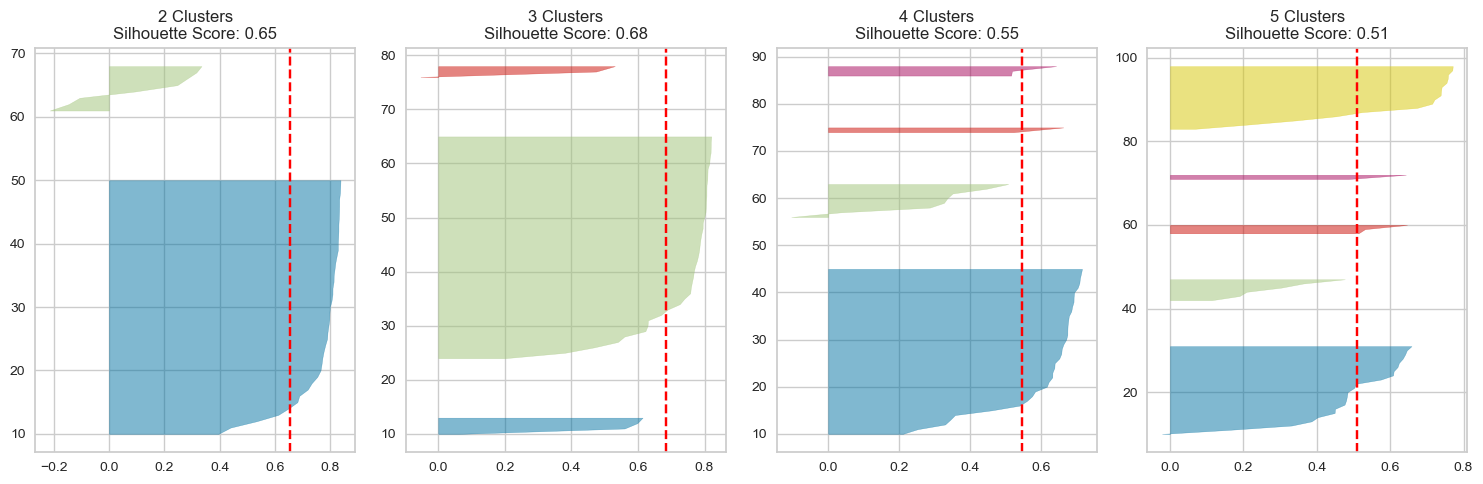

In [12]:
#data
X = db1[['Supplier_quantity_mm', 'Google Hits_mm']]

#number of clusters to try
clusters_list = [2, 3, 4, 5]

#graph
fig, axs = plt.subplots(1, len(clusters_list), figsize=(15, 5))
silhouette_scores = []
for ax, n_clusters in zip(axs, clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # graph
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
    # adjust data to model
    visualizer.fit(X)
    labels = kmeans.labels_
    # Silhoette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    # title with number of clusters and score
    ax.set_title(f'{n_clusters} Clusters\nSilhouette Score: {silhouette_avg:.2f}')

plt.tight_layout()
plt.savefig('Modelling_GH_qtdSuppliers_silhouette_plots_maxsamplesize.png')
plt.savefig('Modelling_GH_qtdSuppliers_silhouette_plots_maxsamplesize.eps')
plt.show()


<span style='color:blue'> From the data distribution results for each cluster group (2, 3, 4, or 5) and the silhouette score it is possible to verify that the best data distribution is made with three clusters (silhouette score = 0.57).


### 4.3. Final model
<a id='4.3'>

C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\AppData\Local\Temp\ipykernel_13052\610045271.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((centroids[cluster_label, 1], centroids[cluster_label, 0]),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


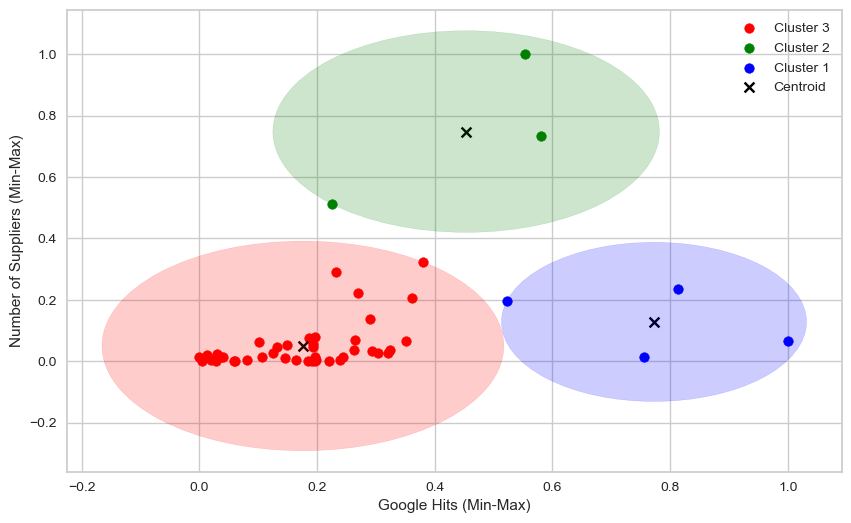

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

data = db1[['Supplier_quantity_mm', 'Google Hits_mm']]

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)

kmeans.fit(data)

db1['Cluster'] = kmeans.labels_

silhouette_avg = silhouette_score(data, kmeans.labels_)

centroids = kmeans.cluster_centers_

cluster_sizes = db1['Cluster'].value_counts()

min_cluster = cluster_sizes.idxmin()
max_cluster = cluster_sizes.idxmax()

new_cluster_colors = {}
for cluster_label in range(num_clusters):
    if cluster_label == min_cluster:
        new_cluster_colors[cluster_label] = 'green'
    elif cluster_label == max_cluster:
        new_cluster_colors[cluster_label] = 'red'
    else:
        new_cluster_colors[cluster_label] = 'blue'

plt.figure(figsize=(10, 6))
for cluster_label in range(num_clusters):
    cluster_data = db1[db1['Cluster'] == cluster_label]
    
    if cluster_label == 0:
        label = 'Cluster 3'
    elif cluster_label == 1:
        label = 'Cluster 2'
    else:
        label = 'Cluster 1'
    
    plt.scatter(cluster_data['Google Hits_mm'], cluster_data['Supplier_quantity_mm'], 
                label=label, color=new_cluster_colors[cluster_label])

plt.scatter(centroids[:, 1], centroids[:, 0], s=50, c='black', marker='x', label='Centroid')

for cluster_label in range(num_clusters):
    cluster_data = db1[db1['Cluster'] == cluster_label]
    distances = np.sqrt((cluster_data['Google Hits_mm'] - centroids[cluster_label, 1]) ** 2 +
                        (cluster_data['Supplier_quantity_mm'] - centroids[cluster_label, 0]) ** 2)
    max_distance = distances.max()
    
    circle = plt.Circle((centroids[cluster_label, 1], centroids[cluster_label, 0]), 
                        max_distance, color=new_cluster_colors[cluster_label], alpha=0.2, fill=True, linestyle='-', edgecolor='black')
    plt.gca().add_patch(circle)

plt.xlabel('Google Hits (Min-Max)')
plt.ylabel('Number of Suppliers (Min-Max)')
plt.legend()
plt.savefig('Modelling_GH_qtdSupplier_clustering_maxsamplesize.eps', dpi=300, transparent=True)
plt.savefig('Modelling_GH_qtdSupplier_clustering_maxsamplesize.png', dpi=300, transparent=True)
plt.show()


In [14]:
# cluster results

db1['Cluster'] = kmeans.labels_
result_table = db1[['Brand', 'Supplier_quantity_mm', 'Google Hits_mm', 'Cluster']]
result_table['Cluster'] = result_table['Cluster'].replace({0: 3, 1: 2, 2: 1})
print(result_table)
#result_table.to_csv('Modelling_clustering_GH_CO2.csv', index=False)

           Brand  Supplier_quantity_mm  Google Hits_mm  Cluster
0           Ford              0.065728        1.000000        1
1            BMW              0.234742        0.812661        1
2         Toyota              0.014085        0.754676        1
3     Volkswagen              0.732394        0.580718        2
4        Porsche              1.000000        0.553956        2
5      Chevrolet              0.197183        0.522733        1
6             MG              0.323944        0.379106        3
7        Ferrari              0.206573        0.360819        3
8         Morgan              0.065728        0.351452        3
9          Mazda              0.037559        0.323797        3
10       Renault              0.028169        0.321121        3
11         Rover              0.028169        0.302833        3
12       Peugeot              0.032864        0.293020        3
13       Triumph              0.136150        0.289451        3
14    Land Rover              0.220657  

C:\Users\InesC\AppData\Local\Temp\ipykernel_13052\2632888559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_table['Cluster'] = result_table['Cluster'].replace({0: 3, 1: 2, 2: 1})


In [15]:
db1['Cluster'] = db1['Cluster'].replace({0: 3, 1: 2, 2: 1})

In [16]:
#ANOVA
anova_supplier = stats.f_oneway(
    db1[db1['Cluster'] == 1]['Supplier_quantity_mm'],
    db1[db1['Cluster'] == 2]['Supplier_quantity_mm'],
    db1[db1['Cluster'] == 3]['Supplier_quantity_mm']
)


anova_google = stats.f_oneway(
    db1[db1['Cluster'] == 1]['Google Hits_mm'],
    db1[db1['Cluster'] == 2]['Google Hits_mm'],
    db1[db1['Cluster'] == 3]['Google Hits_mm']
)
print(f"ANOVA Supplier Quantity Z-Score: F-value = {anova_supplier.statistic}, p-value = {anova_supplier.pvalue}")
print(f"ANOVA Google Hits Z-Score: F-value = {anova_google.statistic}, p-value = {anova_google.pvalue}")

ANOVA Supplier Quantity Z-Score: F-value = 80.23946369903666, p-value = 1.0029706217401123e-15
ANOVA Google Hits Z-Score: F-value = 49.390241738303544, p-value = 3.524516999597298e-12


In [17]:
import pandas as pd

def sum_of_squares(data, global_mean=None):
    if global_mean is None:
        global_mean = data.mean()
    return ((data - global_mean) ** 2).sum()

num_clusters = db1['Cluster'].nunique()

results = {'Supplier_quantity_mm': {}, 'Google_Hits_mm': {}}

global_mean_supplier = db1['Supplier_quantity_mm'].mean()
global_mean_google = db1['Google Hits_mm'].mean()

sst_supplier = sum_of_squares(db1['Supplier_quantity_mm'], global_mean_supplier)
sst_google = sum_of_squares(db1['Google Hits_mm'], global_mean_google)

ssb_supplier = 0
ssb_google = 0

for cluster in range(1, num_clusters + 1):
    db_cluster = db1[db1['Cluster'] == cluster]
    cluster_size = len(db_cluster)
    if cluster_size > 0:
        cluster_mean_supplier = db_cluster['Supplier_quantity_mm'].mean()
        cluster_mean_google = db_cluster['Google Hits_mm'].mean()
        ssb_supplier += cluster_size * (cluster_mean_supplier - global_mean_supplier) ** 2
        ssb_google += cluster_size * (cluster_mean_google - global_mean_google) ** 2

ssw_supplier = sst_supplier - ssb_supplier
ssw_google = sst_google - ssb_google

dfb = num_clusters - 1
dfw_supplier = len(db1) - num_clusters
dfw_google = len(db1) - num_clusters

if dfw_supplier > 0 and dfw_google > 0:
    msb_supplier = ssb_supplier / dfb
    msw_supplier = ssw_supplier / dfw_supplier
    msb_google = ssb_google / dfb
    msw_google = ssw_google / dfw_google

    results['Supplier_quantity_mm'] = {
        'SST': sst_supplier, 'SSB': ssb_supplier, 'SSW': ssw_supplier, 'MSB': msb_supplier, 'MSW': msw_supplier
    }
    results['Google_Hits_mm'] = {
        'SST': sst_google, 'SSB': ssb_google, 'SSW': ssw_google, 'MSB': msb_google, 'MSW': msw_google
    }

    for variable, metrics in results.items():
        print(f"\nResultados para {variable}:")
        print(f"  SST = {metrics['SST']:.4f}")
        print(f"  SSB = {metrics['SSB']:.4f}")
        print(f"  SSW = {metrics['SSW']:.4f}")
        print(f"  MSB = {metrics['MSB']:.4f}")
        print(f"  MSW = {metrics['MSW']:.4f}")
else:
    print("Os graus de liberdade para a Soma dos Quadrados Dentro dos Grupos não são válidos.")



Resultados para Supplier_quantity_mm:
  SST = 1.7620
  SSB = 1.3695
  SSW = 0.3926
  MSB = 0.6847
  MSW = 0.0085

Resultados para Google_Hits_mm:
  SST = 2.1155
  SSB = 1.4434
  SSW = 0.6722
  MSB = 0.7217
  MSW = 0.0146


In [18]:
import pandas as pd

def sum_of_squares(data, global_mean=None):
    if global_mean is None:
        global_mean = data.mean()
    return ((data - global_mean) ** 2).sum()

num_clusters = db1['Cluster'].nunique()

results = {'Supplier_quantity_mm': {}, 'Google_Hits_mm': {}}

global_mean_supplier = db1['Supplier_quantity_mm'].mean()
global_mean_google = db1['Google Hits_mm'].mean()

sst_supplier = sum_of_squares(db1['Supplier_quantity_mm'], global_mean_supplier)
sst_google = sum_of_squares(db1['Google Hits_mm'], global_mean_google)

ssb_supplier = 0
ssb_google = 0

for cluster in range(1, num_clusters + 1):
    db_cluster = db1[db1['Cluster'] == cluster]
    cluster_size = len(db_cluster)
    if cluster_size > 0:
        cluster_mean_supplier = db_cluster['Supplier_quantity_mm'].mean()
        cluster_mean_google = db_cluster['Google Hits_mm'].mean()
        ssb_supplier += cluster_size * (cluster_mean_supplier - global_mean_supplier) ** 2
        ssb_google += cluster_size * (cluster_mean_google - global_mean_google) ** 2

ssw_supplier = sst_supplier - ssb_supplier
ssw_google = sst_google - ssb_google

dfb = num_clusters - 1
dfw_supplier = len(db1) - num_clusters
dfw_google = len(db1) - num_clusters

if dfw_supplier > 0 and dfw_google > 0:
    msb_supplier = ssb_supplier / dfb
    msw_supplier = ssw_supplier / dfw_supplier
    msb_google = ssb_google / dfb
    msw_google = ssw_google / dfw_google

    results['Supplier_quantity_mm'] = {
        'SST': sst_supplier, 'SSB': ssb_supplier, 'SSW': ssw_supplier, 'MSB': msb_supplier, 'MSW': msw_supplier
    }
    results['Google_Hits_mm'] = {
        'SST': sst_google, 'SSB': ssb_google, 'SSW': ssw_google, 'MSB': msb_google, 'MSW': msw_google
    }

    for variable, metrics in results.items():
        print(f"\nResultados para {variable}:")
        print(f"  SST = {metrics['SST']:.4f}")
        print(f"  SSB = {metrics['SSB']:.4f}")
        print(f"  SSW = {metrics['SSW']:.4f}")
        print(f"  MSB = {metrics['MSB']:.4f}")
        print(f"  MSW = {metrics['MSW']:.4f}")
else:
    print("Os graus de liberdade para a Soma dos Quadrados Dentro dos Grupos não são válidos.")



Resultados para Supplier_quantity_mm:
  SST = 1.7620
  SSB = 1.3695
  SSW = 0.3926
  MSB = 0.6847
  MSW = 0.0085

Resultados para Google_Hits_mm:
  SST = 2.1155
  SSB = 1.4434
  SSW = 0.6722
  MSB = 0.7217
  MSW = 0.0146
